<a href="https://colab.research.google.com/github/aritrasen87/LLM_RAG_Model_Deployment/blob/main/LangGraph_9_ReAct_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install langchain-core langchain-community langgraph langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.

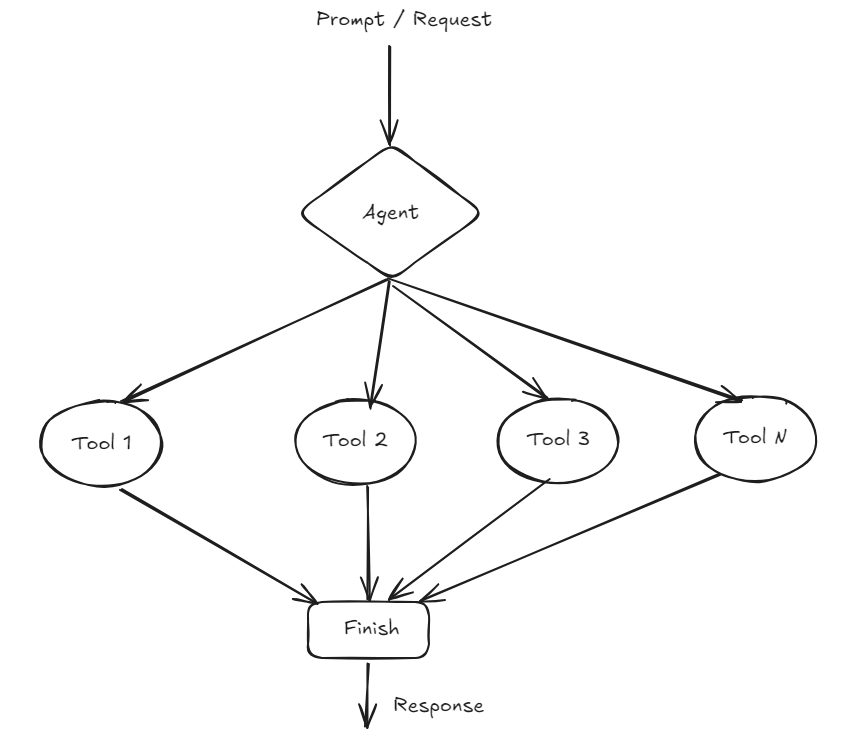

In [ ]:
# Key and llm initialization
import os
from google.colab import userdata
from langchain_openai import ChatOpenAI

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY')

In [ ]:
# Tavily tool initialization
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide, tavily_tool]

llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic and search on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

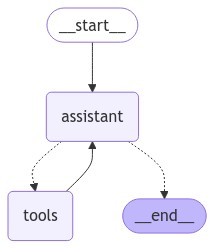

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
app = StateGraph(MessagesState)

# Define nodes: these do the work
app.add_node("assistant", assistant)
app.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
app.add_edge(START, "assistant")
app.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
app.add_edge("tools", "assistant")
react_graph = app.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_q2SjrfnlU6adYC7LHoR4zeD4)
 Call ID: call_q2SjrfnlU6adYC7LHoR4zeD4
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_fyLJ9MXtgI7q7b1ScYk2Y75X)
 Call ID: call_fyLJ9MXtgI7q7b1ScYk2Y75X
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_AhcHH7347jZKpF8lvgHU9Uto)
 Call ID: call_AhcHH7347jZKpF8lvgHU9Uto
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

In [ ]:
messages = [HumanMessage(content="Tell me how many centruries score by Virat Kohli and then tell me the number if we add 20 more to that")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me how many centruries score by Virat Kohli and then tell me the number if we add 20 more to that
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_UPdkseh67utYPY75q86dMWqr)
 Call ID: call_UPdkseh67utYPY75q86dMWqr
  Args:
    query: Virat Kohli total centuries scored 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/List_of_international_cricket_centuries_by_Virat_Kohli", "content": "The next century, which was scored off 61 balls, remains the third-fastest by an Indian as of September 2019[update].[9] As of November 2023[update], Kohli has the most ODI centuries of any player after scoring his 50th ODI century in the 2023 Cricket World Cup knockout stage against New Zealand with a score of 117, and ranks second ove